<a href="https://colab.research.google.com/github/nilakshi104/Basic-Transformer-Model/blob/main/Using_custom_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchtext==0.6.0 #run this cell & restart to avoid error while using bleu_score

     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 1.2MB 26.4MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [2]:
#Pytorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim

#torchtext package consists of data processing utilities and popular datasets for natural language.
import torchtext
from torchtext.data import Field, BucketIterator, TabularDataset

#Plotting graphs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#To tokenize sentence using spacy models
import spacy

#storing \n separated data in tabular form using pd.DataFrame
import pandas as pd

import numpy as np
import random
import math
import time

In [3]:
#to reproduce results
SEED=1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

The code after the ! is not Python but a shell command. It’s an easy way to use these commands in a Jupyter Notebook instead of opening up a terminal and entering the command there.

In [4]:
#Downloading dataset
# ! mkdir -p '/content/drive/MyDrive/Projects/NLP/data/sequence to sequence /German_to_English Basic TransformerModel/multi30k'
# ! wget http://www.quest.dcs.shef.ac.uk/wmt16_files_mmt/training.tar.gz &&  tar -xf training.tar.gz -C '/content/drive/MyDrive/Projects/NLP/data/sequence to sequence /German_to_English Basic TransformerModel/multi30k' && rm training.tar.gz
# ! wget http://www.quest.dcs.shef.ac.uk/wmt16_files_mmt/validation.tar.gz && tar -xf validation.tar.gz -C '/content/drive/MyDrive/Projects/NLP/data/sequence to sequence /German_to_English Basic TransformerModel/multi30k' && rm validation.tar.gz
# ! wget http://www.quest.dcs.shef.ac.uk/wmt16_files_mmt/mmt16_task1_test.tar.gz && tar -xf mmt16_task1_test.tar.gz -C '/content/drive/MyDrive/Projects/NLP/data/sequence to sequence /German_to_English Basic TransformerModel/multi30k' && rm mmt16_task1_test.tar.gz

In [5]:
path='/content/drive/MyDrive/Projects/NLP/data/sequence to sequence /German_to_English Basic TransformerModel/multi30k/'
train_en=open(path+'train.en',encoding='utf-8').read().split('\n')
train_de=open(path+'train.de',encoding='utf-8').read().split('\n')
test_en=open(path+'test.en',encoding='utf-8').read().split('\n')
test_de=open(path+'test.de',encoding='utf-8').read().split('\n')
val_en=open(path+'val.en',encoding='utf-8').read().split('\n')
val_de=open(path+'val.de',encoding='utf-8').read().split('\n')

In [ ]:
#downloading spacy models
!python -m spacy download de
!python -m spacy download en

In [8]:
spacy_de = spacy.load('de')  #loading spacy model for german lang
spacy_en = spacy.load('en')  #loading spacy model for english lang

In [9]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Making Dataset ready for Encoder and Decoder

The best way to work with Torchtext is to turn data in spreadsheet format, no matter the original format of data file. As using Torchtext TabularDataset function we can create datasets from spreadsheet formats for that we need to convert data in CSV formate.

* step 1)store data in dataframe with two coulmns. First col for source language and second col for target language.

* step 2)save dataframe in .csv file

* step 3)pass address of train,validation,test .csv files as input to torchtext.data.TabularDataset which will output train_data,validation_data,test_data

* step 4)Now index all tokens in german and english using SRC.build_vocab and TRG.build_vocab respectively where SRC and TRG are field class instances 

* step 5)Creating Batches using BucketIterator. 

After performing all steps will get train_iterator, valid_iterator, test_iterator with specified batch_size and sentences arranged in ascending order of source length i.e. greman here while creating batch

In [10]:
#Define tokenizer
def tokenize_de(text):
  return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

In [11]:
#defining instance of field class which will perform preprocessing of data. NOTE: Always consider SRC as langauge that is to be translated and TRG as lang to which translation is aimed at. 
SRC=Field(tokenize=tokenize_de,
          init_token='<sos>',
          eos_token='<eos>',
          lower=True,  #Whether to lowercase the text in field.
          batch_first=True)  #since model expects - tensors with batch_dimension first

TRG=Field(tokenize=tokenize_en,
          init_token='<sos>',
          eos_token='<eos>',
          lower=True,
          batch_first=True)

In [12]:
train_data = {'german':[line for line in train_de],'english':[line for line in train_en]}
train_df = pd.DataFrame(train_data, columns=['german','english'])

val_data = {'german':[line for line in val_de],'english':[line for line in val_en]}
val_df = pd.DataFrame(val_data, columns=['german','english'])

test_data = {'german':[line for line in test_de],'english':[line for line in test_en]}
test_df = pd.DataFrame(test_data, columns=['german','english'])
# remove very long sentences and sentences where translations are 
# not of roughly equal lengthdf['eng_len'] = df['English'].str.count(' ')
# df['fr_len'] = df['French'].str.count(' ')
# df = df.query('fr_len < 80 & eng_len < 80')
# df = df.query('fr_len < eng_len * 1.5 & fr_len * 1.5 > eng_len')

In [13]:
train_df.to_csv("/content/drive/MyDrive/Projects/NLP/data/sequence to sequence /German_to_English Basic TransformerModel/multi30k/csv_files/train.csv", index=False)
val_df.to_csv("/content/drive/MyDrive/Projects/NLP/data/sequence to sequence /German_to_English Basic TransformerModel/multi30k/csv_files/val.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/Projects/NLP/data/sequence to sequence /German_to_English Basic TransformerModel/multi30k/csv_files/test.csv", index=False)

In [14]:
data_fields= [('german',SRC),('english',TRG)]  #input language followed by output language

train_data,valid_data,test_data = torchtext.data.TabularDataset.splits(path='/content/drive/MyDrive/Projects/NLP/data/sequence to sequence /German_to_English Basic TransformerModel/multi30k/csv_files/', train='train.csv', validation='val.csv', test='test.csv',format='csv', fields=data_fields)

In [15]:
SRC.build_vocab(train_data, min_freq=2) #words with occurance less than min_freq are replaced with UNK token
TRG.build_vocab(train_data, min_freq=2)

In [16]:
# print(TRG.vocab.stoi['the'])
# print(TRG.vocab.itos[7])

In [17]:
# train_iterator,valid_iterator,test_iterator= BucketIterator.splits(
#     (train_data,val_data,test_data),
#     batch_size=128, 
#     sort_key=lambda x: len(x.src), 
#     # shuffle=True,
#     device=device)
train_iterator = BucketIterator(train_data, batch_size=128, sort_key=lambda x: len(x.german), shuffle=True,device=device)
valid_iterator = BucketIterator(valid_data, batch_size=128, sort_key=lambda x: len(x.german), shuffle=True,device=device)
test_iterator = BucketIterator(test_data, batch_size=128, sort_key=lambda x: len(x.german), shuffle=True,device=device)

## Encoder

In [18]:
class Encoder(nn.Module):
  def __init__(self,
               input_dim,  #vocabulary size
               hid_dim, #second dimension of standard embedding and positional embedding = hid_dim
               n_layers,  #no. of layers of encoder =6 (from paper)
               n_heads,   # no. of heads in multihead = 8 (from ppr)
               pf_dim,  #For positionwise_feedforward layer
               dropout,   # 0.1 (from ppr)
               device,
               max_length=100): #Max 100 words are allowed in sentence

    super().__init__()

    self.device=device
    self.tok_embedding=nn.Embedding(input_dim,hid_dim)
    self.pos_embedding=nn.Embedding(max_length,hid_dim)
    self.layers=nn.ModuleList([EncoderLayer(hid_dim,
                                            n_heads,
                                            pf_dim,
                                            dropout,
                                            device)
                              for _ in range(n_layers)])
    self.dropout=nn.Dropout(dropout)
    self.scale=torch.sqrt(torch.FloatTensor([hid_dim])).to(device)  #WHY TO(DEVICE)??????

  def forward(self,src,src_mask):

    #src =[ batch size, src_len]
    #src_mask=[batch_size,1,1,src_len]  ...In later steps src_mask is applied on energy of dim=[batch_size,n_heads,query_len,src_len] so aacordingly new dim are added in src_mask 

    batch_size= src.shape[0]
    src_len =src.shape[1]

    pos=torch.arange(0,src_len).unsqueeze(0).repeat(batch_size,1).to(self.device)

    # pos = tensor([0,1,2,3-----------,src_len-1],
    #              [0,1,2,3-----------,src_len-1],
    #              [0,1,2,3-----------,src_len-1],
    #              [0,1,2,3-----------,src_len-1],
    #              [0,1,2,3-----------,src_len-1])

    # pos = [batch_size, src_len]

    # Before adding std embedding to pos embedding, std embd are multiplied by sqrt(hid_dim) this supposedly reduces variance in the embeddings and model is difficult to train reliably without this scaling factor. 
    #after adding sqrt(hid_dim)*std_embd to pos_embd, dropout is applied to addition

    src = self.dropout((self.tok_embedding(src)*self.scale)+self.pos_embedding(pos))
    #src = [batch_size,src_len,hid_dim]

    # Different parameters are used in each layer
    for layer in self.layers:
      src=layer(src,src_mask)
    #src=[batch_size,src_len,hid_dim]

    return src

In [19]:
class EncoderLayer(nn.Module):
  def __init__(self,
               hid_dim,
               n_heads,
               pf_dim,
               dropout,
               device):
    
    super().__init__() #To reuse base state. Refer this : https://www.youtube.com/watch?v=tX_v8dgb_7I

    self.self_attn_layer_norm = nn.LayerNorm(hid_dim) # normalizes the values of the features, i.e. across the hidden dimension, so each feature has a mean of 0 and a standard deviation of 1. This allows neural networks with a larger number of layers, like the Transformer, to be trained easier.
    self.ff_layer_norm = nn.LayerNorm(hid_dim)
    self.self_attention = MultiHeadAttentionLayer(hid_dim,n_heads,dropout,device)
    self.positionwise_feedforward=PositionwiseFeedforwardLayer(hid_dim,pf_dim,dropout)
    self.dropout=nn.Dropout(dropout)

  def forward(self,src,src_mask):

    #src = [batch_size,src_len,hid_dim]
    #src_mask = [batch_size,1,1,src_len]   ....It is then unsqueezed so it can be correctly broadcast when applying the mask to the energy

    #self_attention
    _src,_ = self.self_attention(src,src,src,src_mask)

    #dropout is applied on output from self_attention i.e. _src and then src is added followed by layer normalization
    src = self.self_attn_layer_norm(src + self.dropout(_src))
    #src =[batch_size, src_len, hid_dim]

    #positionwise feedforward
    _src = self.positionwise_feedforward(src)

    src = self.ff_layer_norm(src + self.dropout(_src))

    #src = [batch_size,src_len,hid_dim]

    return src

## MultiHeadAttention & FeedForward Layer

In [20]:
class MultiHeadAttentionLayer(nn.Module):
  def __init__(self,hid_dim,n_heads,dropout,device):

    super().__init__()
    #print(hid_dim,n_heads,hid_dim % n_heads)
    assert hid_dim % n_heads == 0
    self.hid_dim = hid_dim
    self.n_heads = n_heads
    self.head_dim = hid_dim // n_heads

    self.fc_q = nn.Linear(hid_dim,hid_dim)
    self.fc_k = nn.Linear(hid_dim,hid_dim)
    self.fc_v = nn.Linear(hid_dim,hid_dim)
    self.fc_o = nn.Linear(hid_dim,hid_dim)

    self.dropout = nn.Dropout(dropout)
    self.scale=torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

  def forward(self,query,key,value,mask=None): #query=key=value=src

    #query = [batch_size, query_len, hid_dim]
    #query = [batch_size, key_len, hid_dim]
    #query = [batch_size, value_len, hid_dim]
    #query_len = key_len = value_len

    batch_size = query.shape[0]

    Q = self.fc_q(query)
    K = self.fc_k(key)
    V = self.fc_v(value)
    #Q = [batch size, query len, hid dim]
    #K = [batch size, key len, hid dim]
    #V = [batch size, value len, hid dim] 

    Q = Q.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
    K = K.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
    V = V.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
    #Q = [batch_size, n_heads, query_len, head_dim]
    #K = [batch_size, n_heads, key_len, head_dim]
    #V = [batch_size, n_heads, value_len, head_dim]

    energy = torch.matmul(Q,K.permute(0,1,3,2))/self.scale
    #energy = [batch_size, n_heads, query_len,key_len]

    if mask is not None:
      energy = energy.masked_fill(mask==0,-1e10) #NOTE: mask is boolean matrix though for False,True values in mask 0,1 are used in masked_fill

    attention = torch.softmax(energy, dim=-1)
    #attention= [batch_size, n_heads, query_len,key_len]

    x = torch.matmul(self.dropout(attention),V)
    #x= [batch_size, n_heads, query_len,head_dim]

    x=x.permute(0,2,1,3).contiguous()
    #x=[batch_size,query_len,n_heads,head_dim]

    #before applying view,contiguous is applied
    x=x.view(batch_size,-1,self.hid_dim)
    #x = [batch size, query len, hid dim]

    x=self.fc_o(x)
    #x = [batch size, query len, hid dim]

    return x,attention

In [21]:
class PositionwiseFeedforwardLayer(nn.Module):
  def __init__(self,hid_dim,pf_dim,dropout):
    super().__init__()
    self.fc_1 = nn.Linear(hid_dim,pf_dim)
    self.fc_2 = nn.Linear(pf_dim,hid_dim)
    self.dropout=nn.Dropout(dropout)

  def forward(self,x):
    #x = [batch size, seq len, hid dim]
        
    x = self.dropout(torch.relu(self.fc_1(x)))
    #x = [batch size, seq len, pf_dim]

    x=self.fc_2(x)
    #x = [batch size, seq len, hid dim]

    return x

## Decoder

In [22]:
class Decoder(nn.Module):
  def __init__(self,
               output_dim,
               hid_dim,
               n_layers,
               n_heads,
               pf_dim,
               dropout,
               device,
               max_length=100): #here also for max 100 words pos embeddings are taken
    super().__init__()
    self.device=device
    self.tok_embedding=nn.Embedding(output_dim,hid_dim)
    self.pos_embedding = nn.Embedding(max_length,hid_dim)
    self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                              n_heads,
                                              pf_dim,
                                              dropout,
                                              device)
                                for _ in range(n_layers)])
    
    self.fc_out = nn.Linear(hid_dim,output_dim)
    self.dropout = nn.Dropout(dropout)
    self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

  def forward(self, trg, enc_src, trg_mask, src_mask):

    #trg = [batch_size,trg_len]
    #enc_src = [batch_size,src_len,hid_dim]
    #trg_mask = [batch_size,1,trg_len,trg_len]
    #src_mask = [batch_size,1,1,src_len]

    batch_size=trg.shape[0]
    trg_len=trg.shape[1]

    pos=torch.arange(0,trg_len).unsqueeze(0).repeat(batch_size,1).to(self.device)
    #pos =[batch_size,trg_len]

    trg = self.dropout((self.tok_embedding(trg)*self.scale)+self.pos_embedding(pos))
    #trg = [batch size, trg len, hid dim]

    for layer in self.layers:
      trg,attention=layer(trg,enc_src,trg_mask,src_mask)
      #trg=[batch_size,trg_len,hid_dim]
      #attention=[batch_size,n_heads,trg_len,src_len]

    output=self.fc_out(trg)

    return output,attention

In [23]:
class DecoderLayer(nn.Module):
  def __init__(self,
              hid_dim,
              n_heads,
              pf_dim,
              dropout,
              device):
    super().__init__()
    self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
    self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
    self.ff_layer_norm = nn.LayerNorm(hid_dim)
    self.self_attention = MultiHeadAttentionLayer(hid_dim,n_heads,dropout,device)
    self.encoder_attention = MultiHeadAttentionLayer(hid_dim,n_heads,dropout,device)
    self.positionwise_feedforward =PositionwiseFeedforwardLayer(hid_dim,pf_dim,dropout)
    self.dropout=nn.Dropout(dropout)

  def forward(self,trg, enc_src, trg_mask,src_mask):

    #trg=[batch size, trg len, hid dim]
    #enc_src=[batch_size,src_len,hid_dim]
    #trg_mask = [batch_size,1,trg_len,trg_len]
    #src_mask = [batch_size,1,1,src_len]

    #self_attention
    _trg,_ = self.self_attention(trg,trg,trg,trg_mask)

    trg = self.self_attn_layer_norm(trg+self.dropout(_trg))
    #trg =[batch_size,trg_len,hid_dim]

    #encoder_attention
    _trg,attention = self.encoder_attention(trg,enc_src,enc_src,src_mask) #attention op from last MultiHeadAttention of decoder

    trg=self.enc_attn_layer_norm(trg+self.dropout(_trg))
    #trg = [batch_size,trg_len,hid_dim]

    #positionwise feedforward

    _trg = self.positionwise_feedforward(trg)

    trg=self.ff_layer_norm(trg + self.dropout(_trg))
    #trg = [batch size, trg len, hid dim]
    #attention = [batch size, n heads, trg len, src len]
    return trg,attention #attention is returned as we can plot it later to observe how may attention is paid by ip to op sentences


## Building Model

In [24]:
class Seq2Seq(nn.Module):
  def __init__(self,
               encoder,
               decoder,
               src_pad_idx,
               trg_pad_idx,
               device):
    super().__init__()

    self.encoder=encoder
    self.decoder = decoder
    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  def make_src_mask(self,src):
    #src=[batch_size,src_len]
    src_mask=(src!=self.src_pad_idx).unsqueeze(1).unsqueeze(2)

    #src_mask=[batch_size,1,1,src_len]

    return src_mask

  def make_trg_mask(self,trg):
    #trg=[batch_size,trg_len]

    trg_pad_mask=(trg!=self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
    #trg_pad_mask=[batch_size,1,1,trg_len]

    trg_len=trg.shape[1]
    trg_sub_mask=torch.tril(torch.ones((trg_len,trg_len),device=self.device)).bool()

    #trg_sub_mask=[trg_len,trg_len]

    trg_mask= trg_pad_mask & trg_sub_mask
    #trg_mask =[batch_size,1,trg_len,trg_len]

    return trg_mask

  def forward(self,src,trg):

    #src=[batch_size,src_len]
    #trg=[batch_size,trg_len]

    src_mask=self.make_src_mask(src)
    trg_mask=self.make_trg_mask(trg)

    #src_mask = [batch size, 1, 1, src len]
    #trg_mask = [batch size, 1, trg len, trg len]

    enc_src=self.encoder(src,src_mask)
    #enc_src=[batch_size,src_len,hid_dim]

    output,attention=self.decoder(trg, enc_src, trg_mask, src_mask)

    #output=[batch_size,trg_len,output_dim]
    #attention=[batch_size,n_heads,trg_len,src_len]

    return output, attention

In [25]:
INPUT_DIM=len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM=256
ENC_LAYERS=3
DEC_LAYERS=3
ENC_HEADS=8
DEC_HEADS=8
ENC_PF_DIM=512
DEC_PF_DIM=512
ENC_DROPOUT=0.1
DEC_DROPOUT=0.1

enc=Encoder(INPUT_DIM,
            HID_DIM,
            ENC_LAYERS,
            ENC_HEADS,
            ENC_PF_DIM,
            ENC_DROPOUT,
            device)

dec=Decoder(OUTPUT_DIM,
            HID_DIM,
            DEC_LAYERS,
            DEC_HEADS,
            DEC_PF_DIM,
            DEC_DROPOUT,
            device)

In [26]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [27]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,039,366 trainable parameters


In [28]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:  # hasaatr: to check if an object has the given named attribute and return true if present, else false.
        nn.init.xavier_uniform_(m.weight.data)

In [29]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
     

In [30]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [31]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #as while caculating loss only trg_pad_idx is considered

In [32]:
def train(model,iterator,optimizer,criterion,clip):
  model.train()
  epoch_loss=0

  for i,batch in enumerate(iterator):
    # print(batch)
    src=batch.german
    trg=batch.english
    optimizer.zero_grad()
    output,_=model(src,trg[:,:-1])
    #output=[batch_size,trg_len-1,output_dim]
    #trg=[batch_size,trg_len]
    output_dim=output.shape[-1]
    output=output.contiguous().view(-1,output_dim)  #since nn.crossentropyloss expects output size=(N,C) and label size=(C) 
    trg=trg[:,1:].contiguous().view(-1)
    #output=[batch size * trg len - 1, output dim]
    #trg=[batch size * trg len - 1]
    loss=criterion(output,trg)
    loss.backward()
    torch.nn.utils.clip_grad_norm(model.parameters(),clip)
    optimizer.step()
    epoch_loss += loss.item()
    
  return epoch_loss/len(iterator)


In [33]:
def evaluate(model, iterator, criterion):
  model.eval()
  epoch_loss = 0
  with torch.no_grad():
    for i,batch in enumerate (iterator):
      src=batch.german
      trg=batch.english
      output, _ = model(src,trg[:,:-1])
      #output = [batch_size,trg_len-1,output dim]
      #trg = [batch_size, trg_len]

      output_dim =output.shape[-1]
      output=output.contiguous().view(-1,output_dim)
      trg =trg[:,1:].contiguous().view(-1)
      #output = [batch_size*trg len - 1, output dim]
      #trg = [batch_size*trg_len-1]
      loss=criterion(output,trg)
      epoch_loss+=loss.item()
  return epoch_loss/len(iterator)

In [34]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [35]:
N_EPOCHS=10
CLIP=1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  start_time = time.time()
  train_loss = train(model,train_iterator,optimizer,criterion,CLIP)
  valid_loss = evaluate(model,valid_iterator,criterion)

  end_time = time.time()
  epoch_mins,epoch_secs=epoch_time(start_time,end_time)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(),'/content/drive/MyDrive/Projects/NLP/data/sequence to sequence /German_to_English Basic TransformerModel/multi30k without using custom dataloader/checkpoints/model.pt')

  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrainLoss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch: 01 | Time: 0m 20s
	TrainLoss: 4.232 | Train PPL:  68.868
	 Val. Loss: 3.068 |  Val. PPL:  21.494
Epoch: 02 | Time: 0m 20s
	TrainLoss: 2.808 | Train PPL:  16.570
	 Val. Loss: 2.358 |  Val. PPL:  10.565
Epoch: 03 | Time: 0m 21s
	TrainLoss: 2.231 | Train PPL:   9.305
	 Val. Loss: 2.023 |  Val. PPL:   7.563
Epoch: 04 | Time: 0m 21s
	TrainLoss: 1.879 | Train PPL:   6.550
	 Val. Loss: 1.862 |  Val. PPL:   6.434
Epoch: 05 | Time: 0m 20s
	TrainLoss: 1.634 | Train PPL:   5.123
	 Val. Loss: 1.776 |  Val. PPL:   5.907
Epoch: 06 | Time: 0m 20s
	TrainLoss: 1.446 | Train PPL:   4.246
	 Val. Loss: 1.692 |  Val. PPL:   5.429
Epoch: 07 | Time: 0m 20s
	TrainLoss: 1.294 | Train PPL:   3.646
	 Val. Loss: 1.678 |  Val. PPL:   5.355
Epoch: 08 | Time: 0m 20s
	TrainLoss: 1.169 | Train PPL:   3.220
	 Val. Loss: 1.668 |  Val. PPL:   5.304
Epoch: 09 | Time: 0m 20s
	TrainLoss: 1.058 | Train PPL:   2.880
	 Val. Loss: 1.676 |  Val. PPL:   5.344
Epoch: 10 | Time: 0m 20s
	TrainLoss: 0.961 | Train PPL:   2.614


In [38]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Projects/NLP/data/sequence to sequence /German_to_English Basic TransformerModel/multi30k without using custom dataloader/checkpoints/model.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.711 | Test PPL:   5.534 |


In [49]:
def translate_sentence(sentence,src_field,trg_field,model,device,max_length=50):
  model.eval()
  if isinstance (sentence,str):
    tokenize_de=spacy.load('de')
    tokens=[token.text for token in tokenize_de(setence)]
  else:
    tokens=[token.lower() for token in sentence]

  #adding sos and eos token to tokens
  tokens=[src_field.init_token]+tokens+[src_field.eos_token]

  #converting tokens(strings) to indexes 
  src_indexes=[src_field.vocab.stoi[token] for token in tokens]
  #Convert to tensor and unsqueeze first dim so batch size=1 
  src_tensor=torch.LongTensor(src_indexes).unsqueeze(0).to(device)
  src_mask=model.make_src_mask(src_tensor)

  with torch.no_grad():
    enc_src=model.encoder(src_tensor,src_mask)

  trg_indexes=[trg_field.vocab.stoi[trg_field.init_token]]

  for i in range(max_length):
    #convert trg_indexes to tensor
    trg_tensor=torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
    trg_mask=model.make_trg_mask(trg_tensor)
    with torch.no_grad():
      # so bascically what happens in decoder part in evaluation, no pad token is fed as input so trg_pad_mask =True always only trg_sub_mask changes with each word in sentence (for evaluation we considered one batch only)
      output,attention=model.decoder(trg_tensor,enc_src,trg_mask,src_mask)
      pred_token=output.argmax(2)[:,-1].item()
      trg_indexes.append(pred_token)

      if pred_token==trg_field.vocab.stoi[trg_field.eos_token]:
        break

  trg_tokens=[trg_field.vocab.itos[i] for i in trg_indexes]

  return trg_tokens[1:],attention

## Plotting Attention:

On X axes:- source sentence (german language) including sos +sentence+ eos

On Y axes:- target sentence (english language) output of deocder i.e. sentence + eos

In [50]:
def display_attention(sentence,translation,attention,n_heads=8,n_rows=4,n_cols=2):
  assert n_rows*n_cols == n_heads
  fig = plt.figure(figsize=(15,25))
  for i in range(n_heads):
    ax=fig.add_subplot(n_rows,n_cols,i+1)
    _attention=attention.squeeze(0)[i].cpu().detach().numpy() #1. transfer attention to cpu from gpu, 2.detach() is used as grad=False, 3.Attention tensor is converted to numpy for plotting
    cax=ax.matshow(_attention,cmap='bone')
    ax.tick_params(labelsize=12)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],rotation=45)
    ax.set_yticklabels(['']+translation) 
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

src = ['ein', 'kleines', 'mädchen', 'sitzt', 'vor', 'einem', 'großen', 'gemalten', 'regenbogen', '.']
trg = ['a', 'little', 'girl', 'is', 'sitting', 'in', 'front', 'of', 'a', 'large', 'painted', 'rainbow', '.']
predicted trg =['a', 'little', 'girl', 'is', 'sitting', 'in', 'front', 'of', 'a', 'large', 'rainbow', '.', '<eos>']


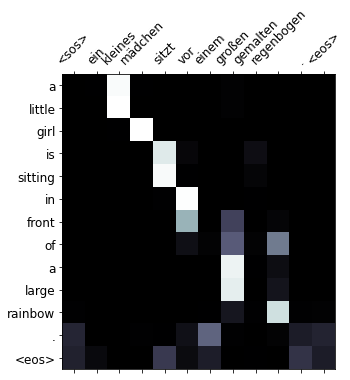

In [51]:
example_idx = 17

src=vars(train_data.examples[example_idx])['german']
trg=vars(train_data.examples[example_idx])['english']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg ={translation}')

display_attention(src, translation, attention)

In [64]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data,src_field,trg_field,model,device,max_len=50):
  trgs=[]
  pred_trgs=[]

  for datum in data:
    src=vars(datum)['german']
    trg=vars(datum)['english']

    pred_trg,_ = translate_sentence(src,src_field,trg_field,model,device,max_len)

    #cutoff <eos> token
    pred_trg=pred_trg[:-1]
    pred_trgs.append(pred_trg)
    trgs.append([trg])

  return bleu_score(pred_trgs, trgs)

In [63]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.60


## Yet to complete (Rough Work)

In [ ]:
#prepare data

SOS_token=0
EOS_token=1
class Lang():
  def __init__(self,name):
    self.name=name
    self.word2index={'SOS':0,'EOS':1,'UNK':2,'PAD':3}
    self.index2word={0:'SOS',1:'EOS',2:'UNK',3:'PAD'}
    self.word2count={}
    self.keepwords=[]
    self.index=4

  def addWord(self,text):
    words=[tok.text for tok in spacy_fr.tokenizer(text.lower())] if (self.name=='french') else [tok.text for tok in spacy_en.tokenizer(text.lower())]
    for word in words:
      # print(word)
      if word not in self.word2index:
        self.word2index[word]=self.index
        self.index2word[self.index]=word
        self.word2count[word]=1
        self.index+=1
      else:
        self.word2count[word]+=1

  def trimvocab(self,min_count):
    for word,count in self.word2count.items():
      if count>=min_count:
        self.keepwords.append(word)
      
    print('Initial no of words={0} and after trimming no of words={1}'.format(len(self.word2count),len(self.keepwords)))
    self.word2index={'SOS':0,'EOS':1,'UNK':2,'PAD':3}
    self.index2word={0:'SOS',1:'EOS',2:'UNK',3:'PAD'}
    self.index=4

    for word in self.keepwords:
      self.addWord(word)


In [ ]:
english=Lang('english')

book=['Girls are there','50m Girls am glade to meet YOU','GiRls ARE glade to MeeT yOU ThEre']
for sent in book:
  english.addWord(sent)

print(english.word2index)
print(english.index2word)
print(english.word2count)

english.trimvocab(2)
print(english.word2index)
print(english.index2word)
print(english.word2count)

{'SOS': 0, 'EOS': 1, 'UNK': 2, 'PAD': 3, 'girls': 4, 'are': 5, 'there': 6, '50': 7, 'm': 8, 'am': 9, 'glade': 10, 'to': 11, 'meet': 12, 'you': 13}
{0: 'SOS', 1: 'EOS', 2: 'UNK', 3: 'PAD', 4: 'girls', 5: 'are', 6: 'there', 7: '50', 8: 'm', 9: 'am', 10: 'glade', 11: 'to', 12: 'meet', 13: 'you'}
{'girls': 3, 'are': 2, 'there': 2, '50': 1, 'm': 1, 'am': 1, 'glade': 2, 'to': 2, 'meet': 2, 'you': 2}
Initial no of words=10 and after trimming no of words=7
{'SOS': 0, 'EOS': 1, 'UNK': 2, 'PAD': 3, 'girls': 4, 'are': 5, 'there': 6, 'glade': 7, 'to': 8, 'meet': 9, 'you': 10}
{0: 'SOS', 1: 'EOS', 2: 'UNK', 3: 'PAD', 4: 'girls', 5: 'are', 6: 'there', 7: 'glade', 8: 'to', 9: 'meet', 10: 'you'}
{'girls': 1, 'are': 1, 'there': 1, '50': 1, 'm': 1, 'am': 1, 'glade': 1, 'to': 1, 'meet': 1, 'you': 1}


In [ ]:
new_book=[]
for sent in book:
  new_word=''
  for word in spacy_en(sent.lower()):
    # print(word.text)
    if word.text in english.word2index.keys():
      new_word=new_word+word.text+' '
    else:
      new_word=new_word+'UNK'+' '
  new_book.append(new_word.strip())

new_book

['girls are there',
 'UNK UNK girls UNK glade to meet you',
 'girls are glade to meet you there']